In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from pickle import load
from cvxopt import matrix, solvers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_data = "/content/drive/MyDrive/Feynn_Labs_Internship/Portfolio_Managment/InputData.csv"
investors = pd.read_csv(input_data, index_col = 0 )
investors.head(1)

,AGE07,EDCL07,MARRIED07,KIDS07,LIFECL07,OCCAT107,INCOME07,RISK07,WSAVED07,SPENDMOR07,NETWORTH07,TrueRiskTol
0,47,2,1,0,2,1,56443.744181,3,1,5,352641.7113,6.947439


In [4]:
returns = "/content/drive/MyDrive/Feynn_Labs_Internship/Portfolio_Managment/returns.csv"
returns = pd.read_csv(returns)

In [5]:
returns

,F,GM,NVDA,ALB,QCOM
0,1.009823,1.005119,1.007137,1.007184,1.008045
1,0.996025,1.007913,0.973325,0.998977,1.002532
2,0.993239,0.992910,0.956990,0.983833,1.001055
3,0.990402,0.986645,1.025692,0.999298,1.015203
4,0.989471,0.991534,1.003349,1.028156,1.001085
...,...,...,...,...,...
355,0.994253,0.977529,0.970743,0.976660,0.998230
356,1.014407,1.002718,0.985963,0.958665,0.990599
357,0.986442,1.000216,0.999665,0.992890,1.002174
358,0.984159,0.944142,0.989018,1.005135,0.988392


In [62]:
def predict_riskTolerance(X_input):

    filename = '/content/drive/MyDrive/Feynn_Labs_Internship/Risk_Tolerance/finalized_model.sav'
    loaded_model = load(open(filename, 'rb'))
    # estimate accuracy on validation set
    predictions = loaded_model.predict(X_input)
    return predictions


In [70]:

features = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07']
okk =investors[features].iloc[-1,:]
predict_riskTolerance(np.asarray(okk).reshape(1,-1))[0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


0.38399258304701717

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


     pcost       dcost       gap    pres   dres
 0:  3.3473e-05 -9.9999e-01  1e+00  0e+00  3e+00
 1:  3.3472e-05 -9.9909e-03  1e-02  5e-17  3e-02
 2:  3.3390e-05 -9.0469e-05  1e-04  7e-17  3e-04
 3:  3.1073e-05  2.2627e-05  8e-06  2e-16  2e-05
 4:  3.0182e-05  2.9566e-05  6e-07  2e-17  2e-07
 5:  3.0166e-05  3.0157e-05  1e-08  2e-16  2e-09
Optimal solution found.
Optimal Weights: [ 2.51e-01  2.50e-01  1.07e-01  1.19e-01  2.73e-01]

F       0.250830
GM      0.249646
NVDA    0.107010
ALB     0.119283
QCOM    0.273231
Name: 0, dtype: float64


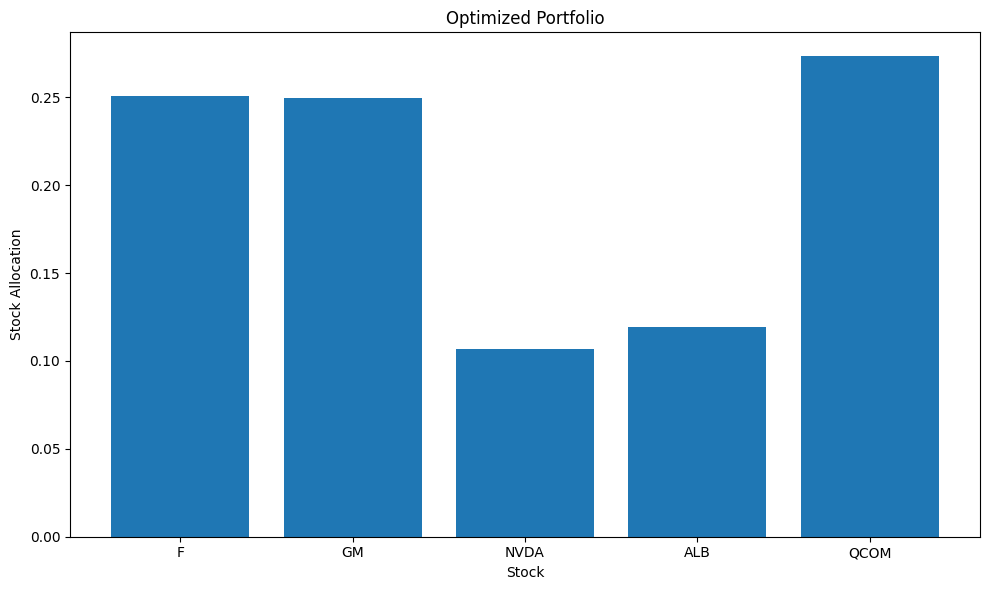

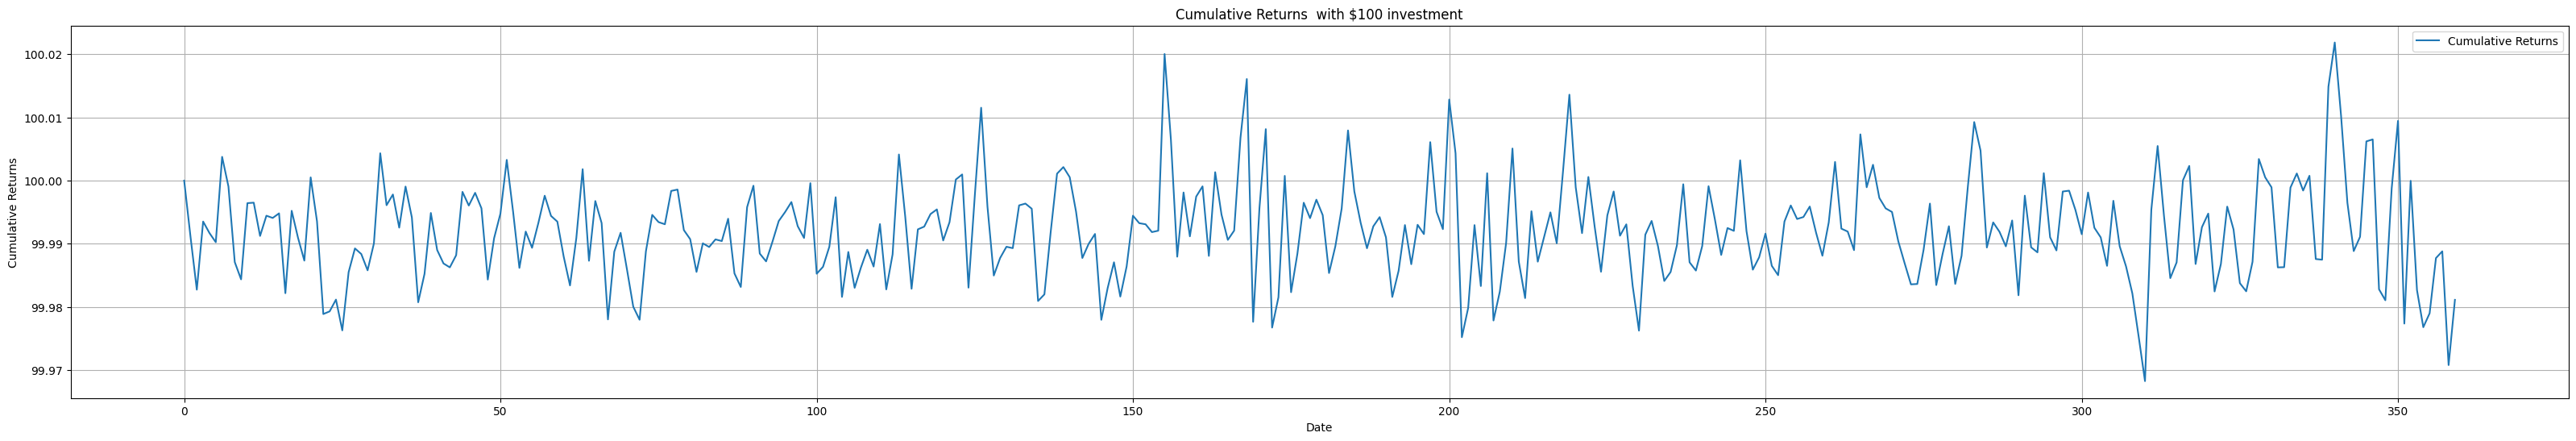

Cumulative Return: -0.00018880592514247674
Annualized Return: -0.0001321678909120827
Annualized Volatility: 0.00148355126567387
Sharpe Ratio: -0.08908885993369996


In [73]:
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def get_asset_allocation(riskTolerance, stock_ticker, assets):
    """
    Perform Markowitz portfolio optimization given a risk tolerance factor and stock tickers.

    Parameters:
    riskTolerance (float): Risk tolerance factor between 0 and 1.
    stock_ticker (list): List of stock tickers.
    assets (DataFrame): DataFrame containing asset prices.

    Returns:
    Alloc (DataFrame): Allocation weights for each stock.
    returns_sum_pd (DataFrame): Cumulative returns starting from 100.
    """
    # Select the assets based on the stock tickers provided
    assets_selected = assets.loc[:, stock_ticker]

    # Calculate the percentage change to get returns
    return_vec = np.array(assets_selected.pct_change().dropna(axis=0)).T
    n = len(return_vec)
    returns = np.asmatrix(return_vec)
    mus = 1 - riskTolerance  # Calculate mus based on risk tolerance

    # Convert to cvxopt matrices
    S = matrix(np.cov(return_vec))  # Covariance matrix
    pbar = matrix(np.mean(return_vec, axis=1))  # Mean returns

    # Create constraint matrices
    G = -matrix(np.eye(n))  # Negative n x n identity matrix for constraints
    h = matrix(0.0, (n, 1))  # Zero vector for the constraints
    A = matrix(1.0, (1, n))  # Sum of weights should be 1
    b = matrix(1.0)  # Sum of weights constraint

    # Solve the optimization problem
    portfolios = solvers.qp( (1-mus)*S, -mus*pbar, G, h, A, b)
    w = portfolios['x'].T  # Transpose the weights
    print("Optimal Weights:", w)

    # Create DataFrame for allocation
    Alloc = pd.DataFrame(data=np.array(portfolios['x']), index=assets_selected.columns)

    # Calculate the final returns
    returns_final = (np.array(assets_selected) * np.array(w))
    returns_sum = np.sum(returns_final, axis=1)

    # Create a DataFrame for the cumulative returns starting at 100
    returns_sum_pd = pd.DataFrame(returns_sum, index=assets.index)  # Adjust index for dropped NaN
    returns_sum_pd = returns_sum_pd - returns_sum_pd.iloc[0, :] + 100

    return Alloc, returns_sum_pd

def allocation_weight(alloc):
    plt.figure(figsize=(10, 6))
    # Convert the data to a list or a numpy array if it's not already
    index = alloc.index
    if isinstance(alloc, pd.Series):
        alloc = alloc.values

    # Create a bar plot
    plt.bar(index,alloc)

    plt.xlabel('Stock')
    plt.ylabel('Stock Allocation')
    plt.title('Optimized Portfolio')

    # Set y-axis format
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
    plt.show()

def plot_returns(returns_sum_pd):
    """
    Plot cumulative returns of the portfolio.

    Parameters:
    returns_sum_pd (DataFrame): Cumulative returns starting from 100.
    """
    plt.figure(figsize=(40, 6))
    plt.plot(returns_sum_pd, label='Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns  with $100 investment')
    plt.legend()
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    plt.grid(True)
    plt.show()

def calculate_metrics(returns_sum_pd):
    """
    Calculate and print portfolio metrics.

    Parameters:
    returns_sum_pd (DataFrame): Cumulative returns starting from 100.

    Returns:
    dict: Dictionary containing portfolio metrics.
    """
    # Calculate daily returns
    daily_returns = returns_sum_pd.pct_change().dropna()

    # Calculate metrics
    cumulative_return = returns_sum_pd.iloc[-1, 0] / returns_sum_pd.iloc[0, 0] - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(returns_sum_pd)) - 1
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    metrics = {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": np.asarray(annualized_volatility)[0],
        "Sharpe Ratio": np.asarray(sharpe_ratio)[0]
    }

    for key, value in metrics.items():
        print(f"{key}: {value}")

    return metrics

# Example usage:
# Assuming you have a DataFrame `assets` with historical stock prices
features = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07']
okk =investors[features].iloc[-1,:]
riskTolerance = predict_riskTolerance(np.asarray(okk).reshape(1,-1))[0]
riskTolerance = 0.9
stock_ticker = ['F',	'GM',	'NVDA',	'ALB',	'QCOM']
# assets = pd.read_csv('path_to_your_assets_data.csv', index_col='Date', parse_dates=True)

Alloc, returns_sum_pd = get_asset_allocation(riskTolerance, stock_ticker, returns)
print(Alloc[0])
allocation_weight(Alloc[0])
plot_returns(returns_sum_pd)
metrics = calculate_metrics(returns_sum_pd)
